# Alpha Vantage API for News Testing

In [2]:
import requests
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

## Get News Data

In [3]:
stock_ticker = "AAPL"
news_topics = "technology,ipo"

In [4]:
API_KEY = "ZD8AJYKXXDC8NVHJ"
article_limit = 1000
base_url = "https://www.alphavantage.co/query"
function = "NEWS_SENTIMENT"
api_key = API_KEY
parameters = f"tickers={stock_ticker}&topics={news_topics}&apikey={api_key}&limit={article_limit}"
url = f"{base_url}?function={function}&{parameters}"
r = requests.get(url)
data = r.json()

# print(data)
articles = data.get("feed", [])

article_df = pd.DataFrame(articles)

{'Information': 'Thank you for using Alpha Vantage! Our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}


In [70]:
article_df = article_df[['time_published', 'title', 'summary', 'overall_sentiment_score']]
article_df['time_published'] = pd.to_datetime(article_df['time_published'], format='%Y%m%dT%H%M%S')
article_df['score'] = article_df['overall_sentiment_score']
article_df.set_index('time_published', inplace=True)
article_df.sort_index(ascending=False, inplace=True,)

In [71]:
news_df = article_df[['score']]

## Calculate a Sentiment Score

In [72]:
# Calculate median sentiment for everyday
df_daily = news_df.resample('D').median()
df_daily.fillna(0, inplace=True)

# Count the number of entries per day
df_daily_count = news_df.resample('D').size()

# If you want to add this count to your existing df_daily DataFrame:
df_daily['entry_count'] = df_daily_count
df_daily['entry_count_ma'] = df_daily['entry_count'].rolling(window=28, center=False).mean()

# Calculate a 28 day moving average of the score
df_daily['score_ma'] = df_daily['score'].rolling(window=28, center=False).mean()

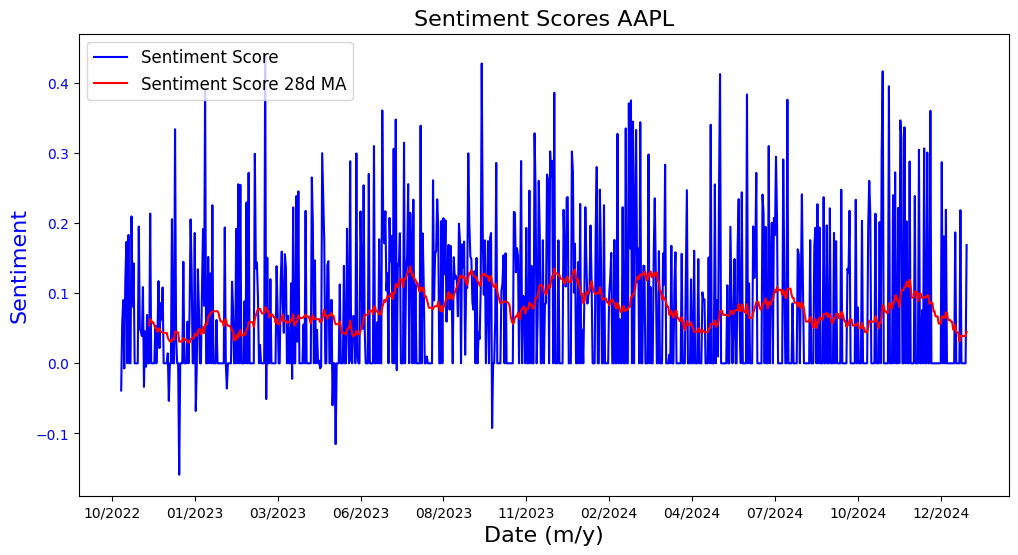

In [73]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_daily.index, 
         df_daily['score'], color='blue', label='Sentiment Score')

ax1.plot(df_daily.index, 
         df_daily['score_ma'], color='red', label='Sentiment Score 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment Scores ' + 'AAPL'.upper(), fontsize=16)

## Get the Stock Price to Compare

In [74]:
# Download the stock price data to compare
msft = yf.Ticker("AAPL")
stock_data = msft.history(period = "9y", interval = "1d")
stock_data.drop('Dividends', axis=1, inplace=True)
stock_data.drop('Stock Splits', axis=1, inplace=True)

# Get a price for every day (including weekends etc)
stock_data = stock_data.resample('D').mean()

# Fill forward price data (carry the price data forward for weekends etc)
stock_data.fillna(method='ffill', inplace=True)

# Get a 28 day and 120 day moving average of the close price
stock_data['close_ma'] = stock_data['Close'].rolling(window=28, center=False).mean()
stock_data['close_120_ma'] = stock_data['Close'].rolling(window=120, center=False).mean()
stock_data.dropna(inplace=True)

# Calculate the short term price movements by subtracting the 120 day MA
stock_data['close_diff'] = stock_data['Close'] - stock_data['close_120_ma']

/var/folders/1k/8slkzd357lj7270s470tsybw0000gn/T/ipykernel_11584/2120882402.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [76]:
# Ensure stock_data index is timezone-naive
stock_data.index = stock_data.index.tz_localize(None)

# Get the first date from stock_data
specific_date = stock_data.index[0]

# Ensure df_daily index is timezone-naive
df_daily.index = df_daily.index.tz_localize(None)

# Filter the DataFrame to get data after the specific date
df_after_specific_date = df_daily.loc[specific_date:]

## Plot the results!

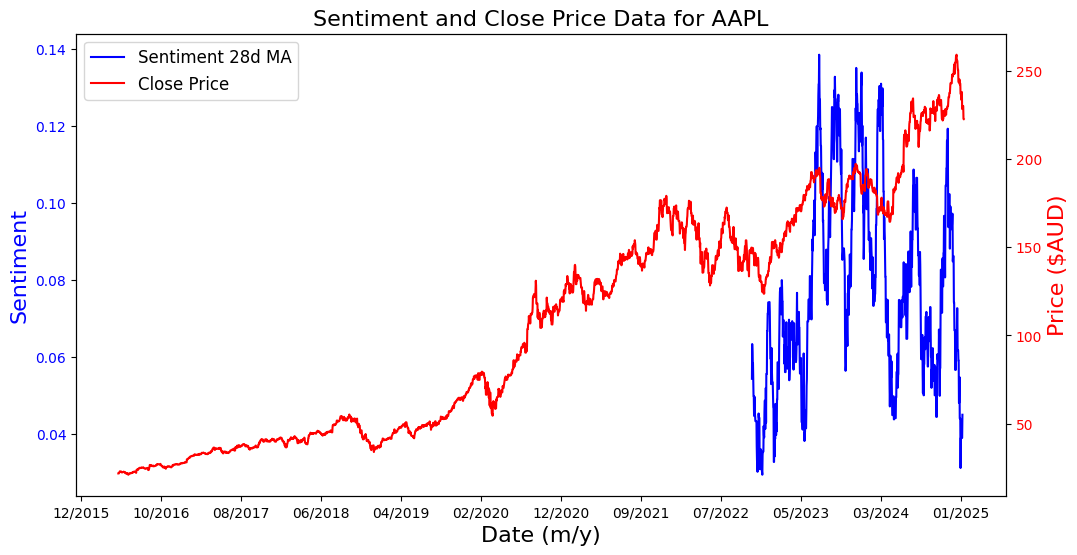

In [77]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['Close'], 
         color='red', label='Close Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Close Price Data for ' + "AAPL", fontsize=16)

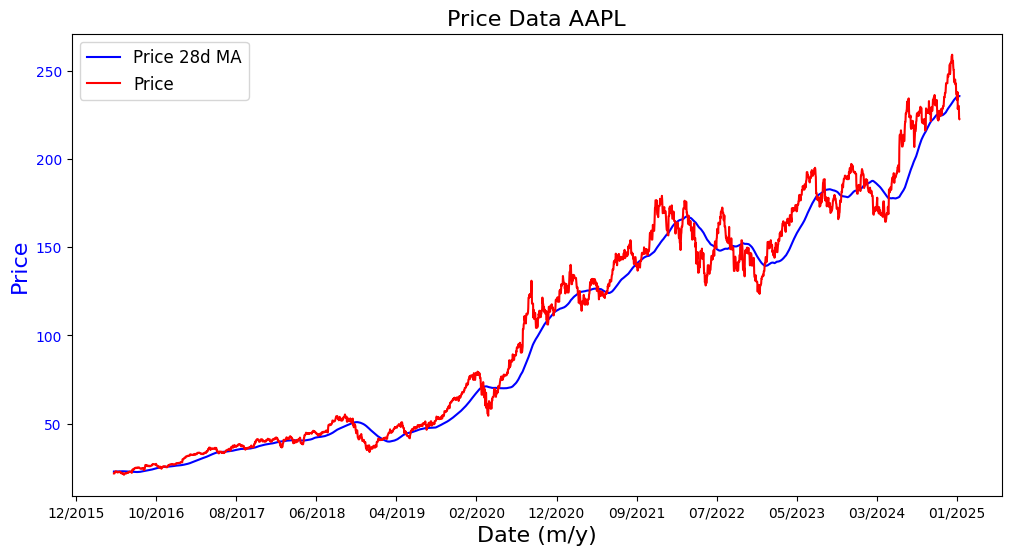

In [78]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(stock_data.index, 
         stock_data['close_120_ma'], color='blue', label='Price 28d MA')

ax1.plot(stock_data.index, 
         stock_data['Close'], color='red', label='Price')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Price Data ' + "AAPL", fontsize=16)

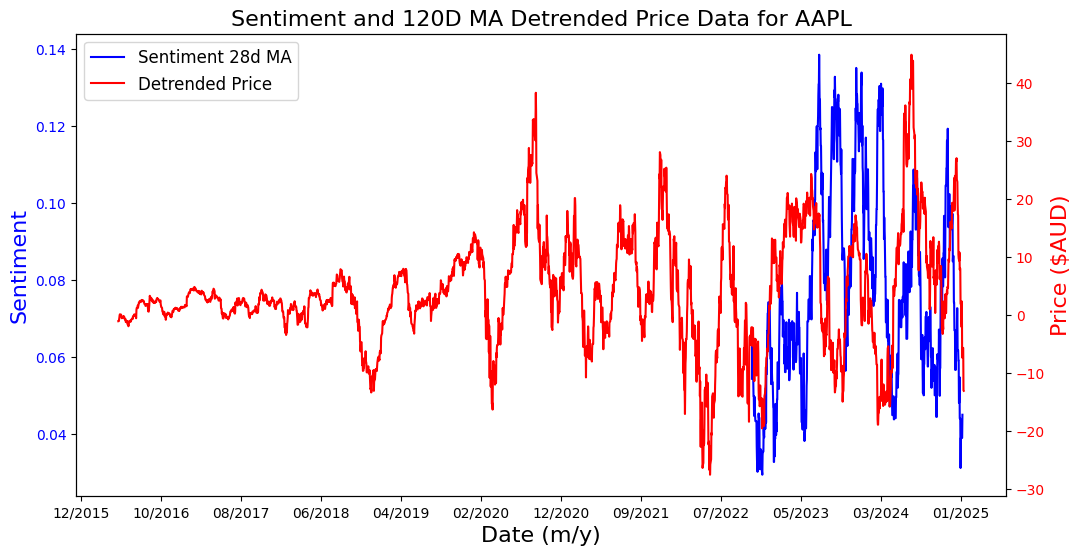

In [79]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['close_diff'], 
         color='red', label='Detrended Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and 120D MA Detrended Price Data for ' + "AAPL", fontsize=16)

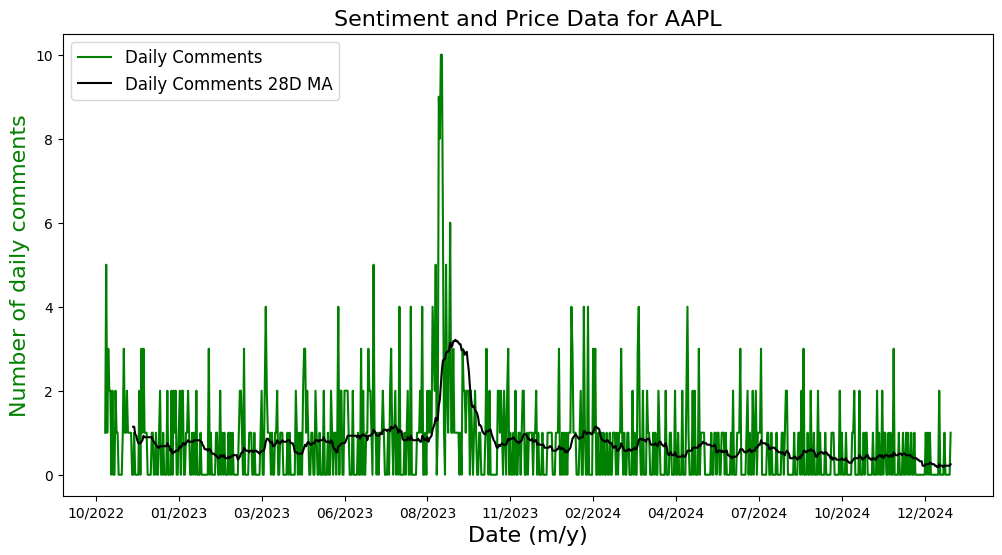

In [80]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count'], color='green', label='Daily Comments')

ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count_ma'], color='k', label='Daily Comments 28D MA')

ax1.set_ylabel('Number of daily comments', color='green', fontsize=16)
ax1.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Add legend
ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Price Data for ' + "AAPL", fontsize=16)